# Prepare data

In [1]:
from script.func_split_data import split_data

In [2]:
split_df = split_data(data_path='Cosmenet_uat_20231108', data_csv='data_last_join_2023_11_10.csv')
split_df.split_data()
split_df.report_train_test_split()
print()
split_df.report_train_test_val_split()

amount of all data : 94493
amount of all class : 21250
amount of data 2-8 img : 3148
amount of 2-8 img class : 571
amount of data more 8 img : 75208
amount of more 8 img class : 4542
amount of data & class only one : 16137

amount of train split : 49340
amount of train split class : 3724
amount of test split : 12338
amount of test split class : 3724
amount of train val : 10826
amount of train val class : 818
amount of test val : 2704
amount of test val class : 818
amount of train val mix : 12400
amount of train val mix class : 1389
amount of test val mix : 4278
amount of test val mix class : 1389


In [3]:
df_train_split, df_test_split = split_df.get_train_test()
df_train_val_mix, df_test_val_mix = split_df.get_validate()

In [4]:
df_train_split.head(1)

,file_names,labels,images_path,BID,SCID,CID,Action
0,46985_13.png,46985,/app/nfs_clientshare/Datasets/Cosmenet_product...,4169,84,53,1


In [5]:
df = split_df.get_dict()

# extract and put to elasticsearch

In [6]:
import torch
from transformers import ViTImageProcessor, ViTModel

from script.func_extract_feature import select_transformers_model, pipeline_transformer
from script.tool import ROOT_NFS_TEST

2023-11-28 09:21:33.598243: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-28 09:21:34.463931: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 09:21:34.464033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 09:21:34.472220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 09:21:35.247676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, preprocess = select_transformers_model(
    ViTModel, ViTImageProcessor, pretrain=ROOT_NFS_TEST / 'weights/vitgg_lr2e05_ep3_loss0.0')
model.load_state_dict(torch.load(
    ROOT_NFS_TEST / 'weights/temp_epoch/vitgg_lr2e05_ep12_loss0.00127.pth')['model_state_dict'])
vit_gg_trained_lr2e_05_pipe = pipeline_transformer(layer="last_hidden_state", row=0, device=device)
vit_gg_trained_lr2e_05_pipe.selct_model(model, preprocess)
vit_gg_trained_lr2e_05_pipe.report_test()

runtime : 2203.795909881592 ms
outputs layers : odict_keys(['last_hidden_state', 'pooler_output'])
shape last_hidden_state : torch.Size([1, 197, 768])
shape pooler_output : torch.Size([1, 768])


In [11]:
from script.func_query_score import extract_to_es

In [31]:
ext_ep3_crop = extract_to_es('vitgg_lr2e05_ep12_loss0.00127_95k_train', url='localhost:9200')
ext_ep3_crop.check_index_exist()
ext_ep3_crop.put_all_tag(vit_gg_trained_lr2e_05_pipe, df, replace=False, crop=False)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'vitgg_lr2e05_ep12_loss0.00127_95k_train'}


/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Parameter [similarity] has no effect on type [dense_vector] and will be removed in future
  warnings.warn(message, category=ElasticsearchWarning)
/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Parameter [index] has no effect on type [dense_vector] and will be removed in future
  warnings.warn(message, category=ElasticsearchWarning)


train_split:   0%|          | 0/49340 [00:00<?, ?it/s]

/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


put tag train_split success


test_split:   0%|          | 0/12338 [00:00<?, ?it/s]

put tag test_split success


train_val:   0%|          | 0/12400 [00:00<?, ?it/s]

put tag train_val success


test_val:   0%|          | 0/4278 [00:00<?, ?it/s]

put tag test_val success


one_img:   0%|          | 0/16137 [00:00<?, ?it/s]

put tag one_img success


In [7]:
import os
import time

In [13]:
files[0][:-4]

'vitgg_lr2e05_ep15_loss0.00217'

In [14]:
weight_dir = ROOT_NFS_TEST / "weights" / "temp_epoch"
while 1:
    files = os.listdir(weight_dir)
    for weight in files:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model, preprocess = select_transformers_model(
            ViTModel, ViTImageProcessor, pretrain=ROOT_NFS_TEST / 'weights/vitgg_lr2e05_ep3_loss0.0')
        model.load_state_dict(torch.load(
            weight_dir / weight)['model_state_dict'])
        vit_gg_trained_lr2e_05_pipe = pipeline_transformer(layer="last_hidden_state", row=0, device=device)
        vit_gg_trained_lr2e_05_pipe.selct_model(model, preprocess)
        vit_gg_trained_lr2e_05_pipe.report_test()

        ext = extract_to_es(weight[:-4] + '_95k_train', url='localhost:9200')
        ext.check_index_exist()
        ext.put_all_tag(vit_gg_trained_lr2e_05_pipe, df, replace=False, crop=False)

        os.rename(weight_dir / weight, ROOT_NFS_TEST / "weights" / 'measure' / weight)
    time.sleep(3600)

runtime : 445.7521438598633 ms
outputs layers : odict_keys(['last_hidden_state', 'pooler_output'])
shape last_hidden_state : torch.Size([1, 197, 768])
shape pooler_output : torch.Size([1, 768])
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'vitgg_lr2e05_ep15_loss0.00217_95k_train'}


/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Parameter [similarity] has no effect on type [dense_vector] and will be removed in future
  warnings.warn(message, category=ElasticsearchWarning)
/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Parameter [index] has no effect on type [dense_vector] and will be removed in future
  warnings.warn(message, category=ElasticsearchWarning)


train_split:   0%|          | 0/49340 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Extract Elasticnet b1

In [10]:
from script.func_extract_feature import select_timm_model, pipeline_timm

In [40]:
model, preprocess = select_timm_model('efficientnet_b1', num_classes=0, pretrain=True)
eff_pipe = pipeline_timm(device=device)
eff_pipe.selct_model(model, preprocess)
eff_pipe.report_test()

runtime : 179.80599403381348 ms
Output shape at layer : torch.Size([1, 1280])


In [41]:
eff = extract_to_es('efficientnet_b1')
eff.check_index_exist(dims=1280)
eff.put_all_tag(eff_pipe, df, replace=False, crop=False)

index efficientnet_b1 already exists


  0%|          | 0/38474 [00:00<?, ?it/s]

put tag train_split success


  0%|          | 0/9620 [00:00<?, ?it/s]

put tag test_split success


  0%|          | 0/9204 [00:00<?, ?it/s]

/tmp/ipykernel_330647/2751088454.py:35: DeprecationWarning: The 'body' parameter is deprecated for the 'index' API and will be removed in a future version. Instead use the 'document' parameter. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  self.es.index(index=self.name_index, id=tag+"_"+str(n), body=data)


put tag train_val success


  0%|          | 0/2881 [00:00<?, ?it/s]

put tag test_val success


# measure_score

In [1]:
from script.func_query_score import measure_score, report_image

In [2]:
url = "localhost:9200"

In [3]:
measure_95k = measure_score("vitgg_lr2e05_ep3_loss0.0_95k", url=url)
result_95k = measure_95k.report_acc(filter_all=True)

/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in count requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


test_val:   0%|          | 0/4278 [00:00<?, ?it/s]

/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


validate score : [80.69 86.4  88.29 89.39 90.21]


test_split:   0%|          | 0/12338 [00:00<?, ?it/s]

split score : [84.8  91.36 93.27 94.3  94.99]


test_val:   0%|          | 0/4278 [00:00<?, ?it/s]

test_split:   0%|          | 0/12338 [00:00<?, ?it/s]

split+val score : [80.74 88.   90.33 91.6  92.46]


# Show image

Split :


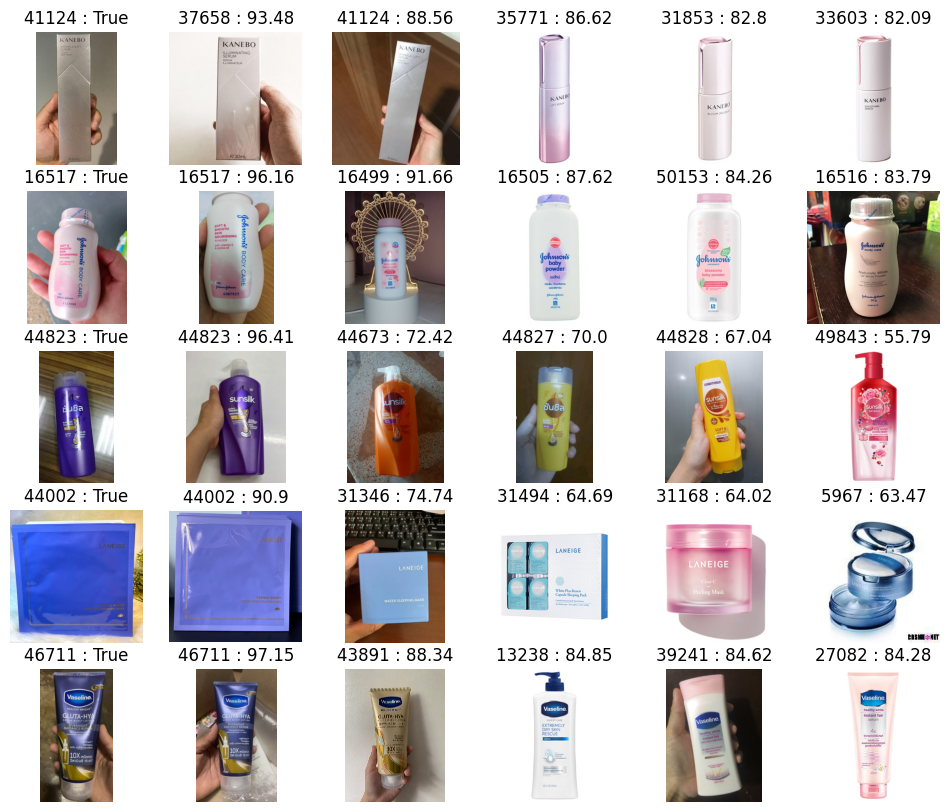



Validate :


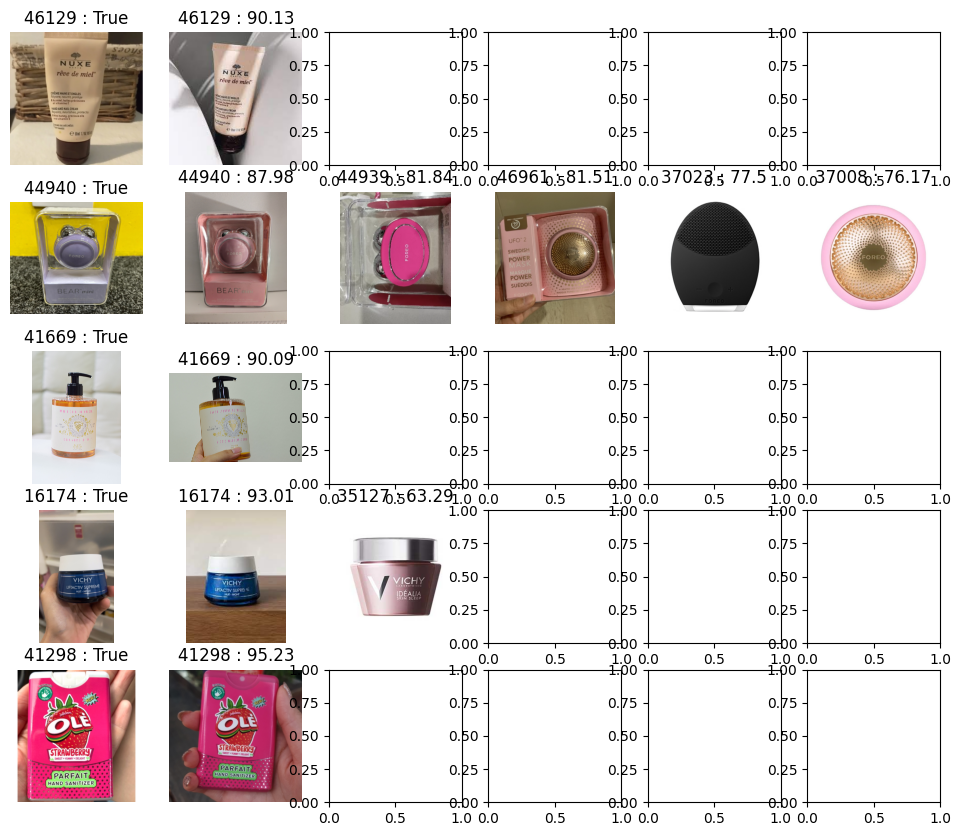



Split + Validate :


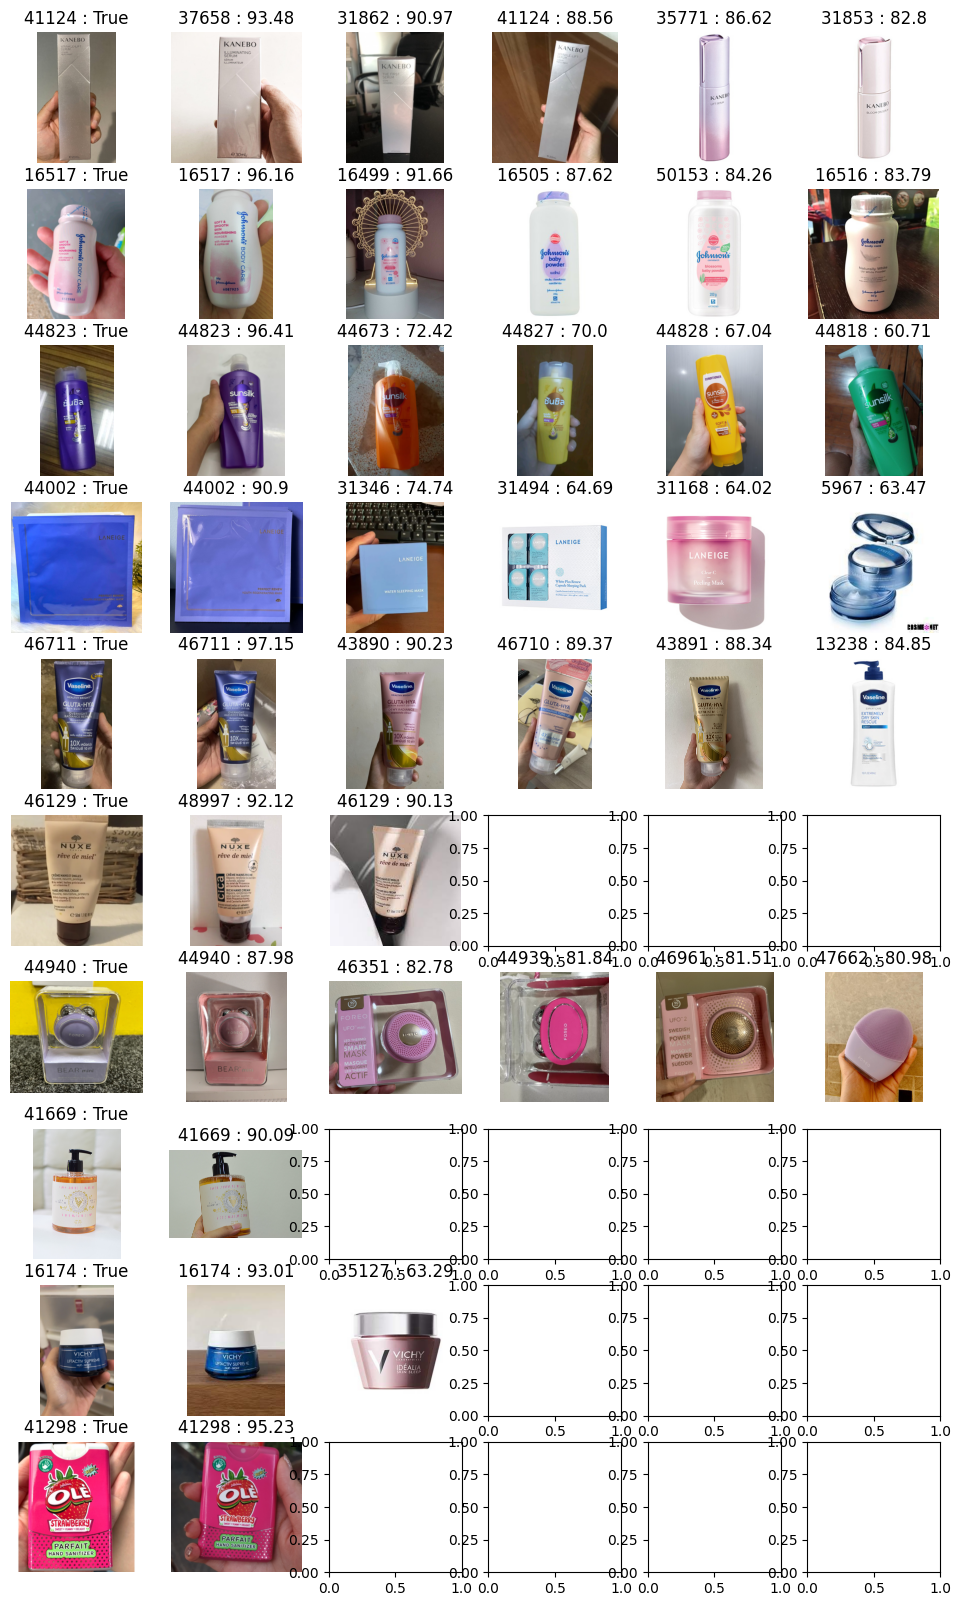

In [4]:
report = report_image(name_index="vitgg_lr2e05_ep3_loss0.0_95k", url=url)
rand_id_split, rand_id_val = report.show_report(num_product=5, top_n=5, collapse=True, filter_all=True)

# put dummy vector to ES

In [83]:
from script.func_query_score import ES_access

In [84]:
dummy_768 = ES_access(name_index="dummy_768")
dummy_768.check_index_exist(dims=768)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'dummy_768'}


/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Parameter [similarity] has no effect on type [dense_vector] and will be removed in future
  warnings.warn(message, category=ElasticsearchWarning)
/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Parameter [index] has no effect on type [dense_vector] and will be removed in future
  warnings.warn(message, category=ElasticsearchWarning)


False

In [85]:
dummy_1280 = ES_access(name_index="dummy_1280")
dummy_1280.check_index_exist(dims=1280)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'dummy_1280'}


False

In [86]:
import numpy as np
from script.tool import to_unit_len
from tqdm.notebook import tqdm
from elasticsearch.helpers import bulk
import uuid
import random

In [117]:
batch = 1000
n_data = 40000
def put_dummy(es, index, n_data, batch, dims):
    document_list = []
    tag_list = ['train_split', 'test_spllit', 'train_val', 'test_val']
    count_taglist = [0]*4
    n_tag_list = range(4)
    max_labels = 3000
    for i in tqdm(range(n_data)):
        f_name = str(uuid.uuid4())+'.jpg'
        n_tag = random.choice(n_tag_list)
        document_list.append({
            "tag": tag_list[n_tag],
            "labels": random.randint(0, max_labels),
            "file_names": f_name,
            "images_path": 'uploads/'+f_name,
            "id": tag_list[n_tag]+"_"+str(count_taglist[n_tag]),
            "features": to_unit_len(np.random.random_sample(dims))
        })
        count_taglist[n_tag] += 1
        if (i+1) % batch == 0:
            bulk(es, document_list, index=index)
            document_list = []
    if (i+1) % batch != 0:
        bulk(es, document_list, index=index)

In [118]:
put_dummy(dummy_1280.es, dummy_1280.name_index, n_data, batch, 1280)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [119]:
put_dummy(dummy_768.es, dummy_768.name_index, n_data, batch, 768)

  0%|          | 0/40000 [00:00<?, ?it/s]

# Experiment Run Time

In [90]:
from script.func_query_body import query_cosine
import time

In [101]:
def measure_time(es, index, n_loop, dims):
    search_time = 0
    for i in tqdm(range(n_loop)):
        st = time.time()
        es.search(index=index,doc_type='_doc',
                  body=query_cosine(to_unit_len(np.random.random_sample(dims)), 
                                    ['train_split', 'test_spllit', 'train_val', 'test_val'], top_n=5))
        search_time += time.time() - st
    return round(search_time/n_loop * 1000, 2)

In [105]:
n_loop = 100

In [120]:
time_eff = measure_time(dummy_1280.es, dummy_1280.name_index, n_loop, 1280)
print(time_eff)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_462358/2093783230.py:5: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.search(index=index,doc_type='_doc',
/app/nfs_clientshare/mew/project_venv/similarity/lib/python3.11/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in search requests is deprecated.
  warnings.warn(message, category=ElasticsearchWarning)


777.54


In [121]:
time_vit = measure_time(dummy_768.es, dummy_768.name_index, n_loop, 768)
print(time_vit)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_462358/2093783230.py:5: DeprecationWarning: The 'body' parameter is deprecated for the 'search' API and will be removed in a future version. Instead use API parameters directly. See https://github.com/elastic/elasticsearch-py/issues/1698 for more information
  es.search(index=index,doc_type='_doc',


455.55
